In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from prophet import Prophet


/Users/prathosh/prathosh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load processed main dataset
hdb_model = pd.read_csv('HDB_model_ready.csv')


In [4]:
hdb_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217372 entries, 0 to 217371
Data columns (total 17 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   floor_area_sqm                            217372 non-null  float64
 1   lease_commence_year                       217372 non-null  int64  
 2   resale_price                              217372 non-null  float64
 3   distance_to_nearest_primary_school_km     217372 non-null  float64
 4   distance_to_nearest_high_value_school_km  217372 non-null  float64
 5   distance_to_nearest_mrt_km                217372 non-null  float64
 6   distance_to_nearest_hawker_km             217372 non-null  float64
 7   distance_to_nearest_mall_km               217372 non-null  float64
 8   distance_to_cbd_km                        217372 non-null  float64
 9   year                                      217372 non-null  int64  
 10  month_num           

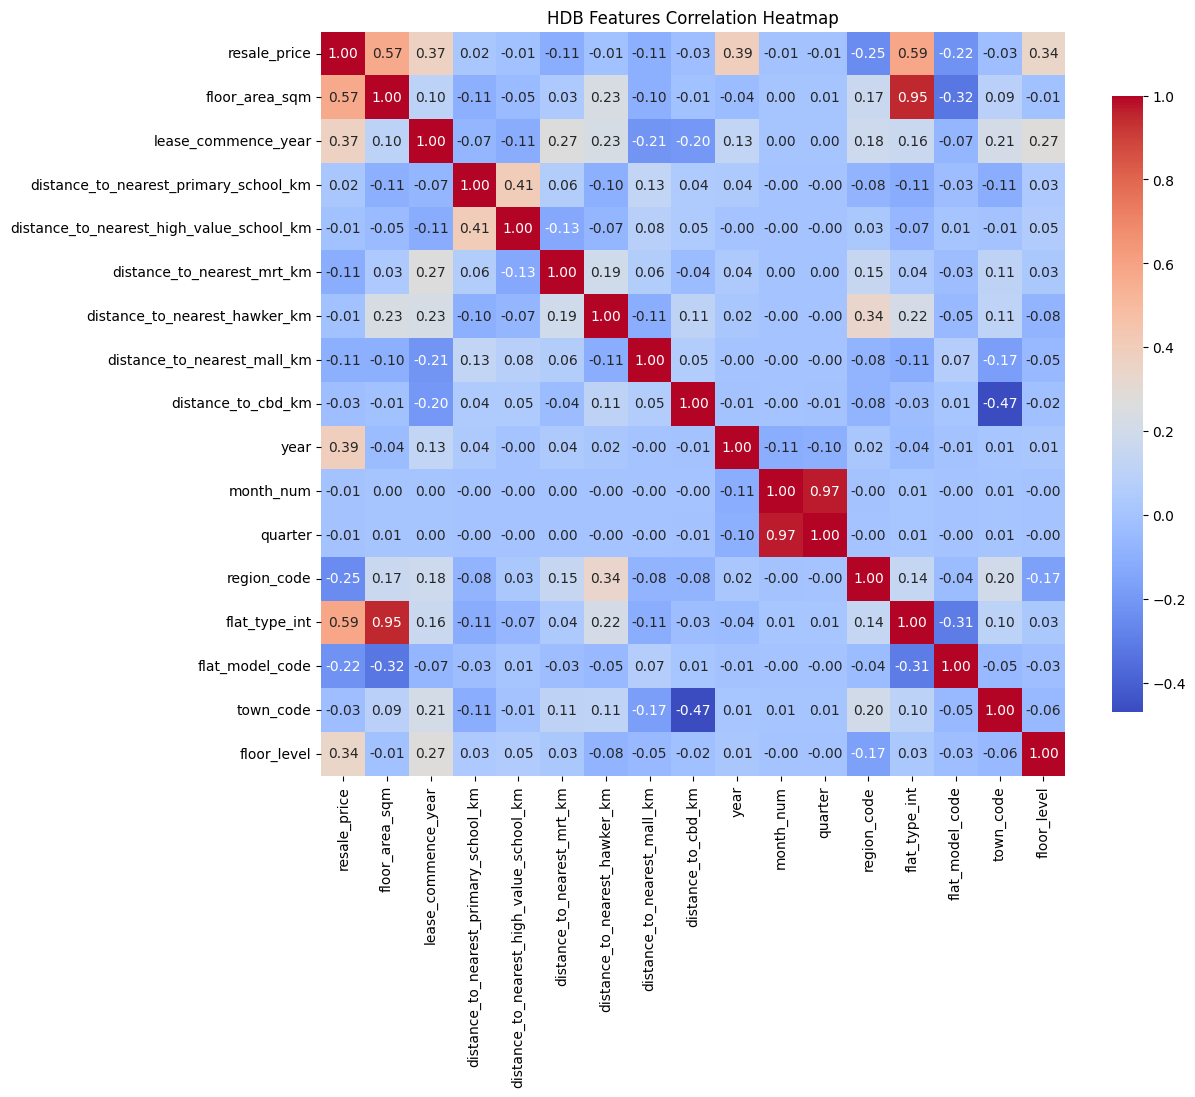

In [6]:
# keep resale_price first
cols = ['resale_price'] + [c for c in hdb_model.columns if c != 'resale_price']
hdb_model = hdb_model[cols]

corr = hdb_model.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,       # show values in cells [web:23][web:16]
    fmt=".2f",        # 2 decimal places [web:27][web:8]
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title('HDB Features Correlation Heatmap')
plt.show()

In [7]:
# Dataset with flat_type_int in [3,4,5]
ds_imp_rooms = hdb_model[hdb_model['flat_type_int'].isin([3,4,5])]

# Main dataset (ALL rows)
ds_all = hdb_model.copy()

# Datasets split by region_code
ds_region_0 = hdb_model[hdb_model['region_code'] == 0]
ds_region_1 = hdb_model[hdb_model['region_code'] == 1]
ds_region_2 = hdb_model[hdb_model['region_code'] == 2]

# Split ds_imp_rooms by region_code
ds_imp_rooms_0 = ds_imp_rooms[ds_imp_rooms['region_code'] == 0]
ds_imp_rooms_1 = ds_imp_rooms[ds_imp_rooms['region_code'] == 1]
ds_imp_rooms_2 = ds_imp_rooms[ds_imp_rooms['region_code'] == 2]


In [8]:
def year_split(df):
    train = df[df['year'] < 2024]
    test = df[df['year'] >= 2024]
    X_train = train.drop(columns=['resale_price'])
    y_train = train['resale_price']
    X_test = test.drop(columns=['resale_price'])
    y_test = test['resale_price']
    return X_train, X_test, y_train, y_test


# Datasets dictionary keys and corresponding DataFrames
dataset_names = [
    'imp_rooms', 'imp_rooms_0', 'imp_rooms_1', 'imp_rooms_2',
    'all', 'region_0', 'region_1', 'region_2'
]

dataset_list = [
    ds_imp_rooms, ds_imp_rooms_0, ds_imp_rooms_1, ds_imp_rooms_2,
    ds_all, ds_region_0, ds_region_1, ds_region_2
]

splits = {}

for name, dataset in zip(dataset_names, dataset_list):
    X_train, X_test, y_train, y_test = year_split(dataset)
    splits[name] = (X_train, X_test, y_train, y_test)



In [9]:
results = {}

for name, (X_train, X_test, y_train, y_test) in splits.items():
    models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=0),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

    model_result = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        model_result[model_name] = {
            'model': model,
            'mae': mae,
            'r2': r2,
            'feature_importance': getattr(model, 'feature_importances_', None)
        }
    results[name] = model_result

# Print accuracy for each dataset and model
for ds_name, model_dict in results.items():
    print(f"\n=== Results for dataset: {ds_name} ===")
    for m_name, res in model_dict.items():
        print(f"{m_name}: MAE = {res['mae']:.2f}, R² = {res['r2']:.4f}")


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1788
[LightGBM] [Info] Number of data points in the train set: 153448, number of used features: 16
[LightGBM] [Info] Start training from score 478721.163625


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 30086, number of used features: 15
[LightGBM] [Info] Start training from score 572923.160905


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1735
[LightGBM] [Info] Number of data points in the train set: 73145, number of used features: 15
[LightGBM] [Info] Start training from score 478724.500536


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 50217, number of used features: 15
[LightGBM] [Info] Start training from score 422278.019499


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 169150, number of used features: 16
[LightGBM] [Info] Start training from score 490971.586248


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 31806, number of used features: 15
[LightGBM] [Info] Start training from score 574017.603502


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1772
[LightGBM] [Info] Number of data points in the train set: 80820, number of used features: 15
[LightGBM] [Info] Start training from score 493770.481047


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1781
[LightGBM] [Info] Number of data points in the train set: 56524, number of used features: 15
[LightGBM] [Info] Start training from score 440239.714788

=== Results for dataset: imp_rooms ===
RandomForest: MAE = 58667.08, R² = 0.8435
DecisionTree: MAE = 60568.07, R² = 0.8237
LinearRegression: MAE = 68540.61, R² = 0.7191
ElasticNet: MAE = 74022.24, R² = 0.6194
MLPRegressor: MAE = 161426.56, R² = 0.0131
XGBoost: MAE = 56985.51, R² = 0.8541
LightGBM: MAE = 59879.59, R² = 0.8313
CatBoost: MAE = 57783.30, R² = 0.8497
KNN: MAE = 77391.47, R² = 0.6888

=== Results for dataset: imp_rooms_0 ===
RandomForest: MAE = 72070.69, R² = 0.8950
DecisionTree: MAE = 74748.05, R² = 0.8796
LinearRegression: MAE = 83389.77, R² = 0.8225
ElasticNet: MAE = 

In [7]:
X_train, X_test, y_train, y_test = year_split(ds_all)


In [8]:

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=0),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'model': model, 'mae': mae, 'r2': r2}
    print(f"{name}: MAE = {mae:.2f}, R² = {r2:.4f}")


RandomForest: MAE = 59073.06, R² = 0.8601
DecisionTree: MAE = 60759.71, R² = 0.8433
LinearRegression: MAE = 69592.18, R² = 0.7467
ElasticNet: MAE = 74796.84, R² = 0.6637


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor: MAE = 156624.46, R² = 0.1721
XGBoost: MAE = 57318.73, R² = 0.8703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 169150, number of used features: 16
[LightGBM] [Info] Start training from score 490971.586248
LightGBM: MAE = 60388.56, R² = 0.8483
CatBoost: MAE = 58301.29, R² = 0.8642
KNN: MAE = 78288.21, R² = 0.7321


In [9]:
# Use monthly average resale_price for ARIMA — example assumes 'month_num' and 'year' columns exist

df_arima = ds_all.groupby(['year', 'month_num'])['resale_price'].mean().reset_index()

# Rename 'month_num' to 'month' for proper datetime parsing
df_arima['date'] = pd.to_datetime(df_arima.rename(columns={'month_num': 'month'})[['year', 'month']].assign(day=1))

ts = df_arima.set_index('date')['resale_price']


# Train/test split for ARIMA time series
train_ts = ts[ts.index.year < 2024]
test_ts = ts[ts.index.year >= 2024]

# Fit ARIMA model (example parameters, tune as needed)
arima_model = sm.tsa.ARIMA(train_ts, order=(5,1,0))
arima_res = arima_model.fit()

# Predict on test set dates
pred_arima = arima_res.predict(start=test_ts.index[0], end=test_ts.index[-1], typ='levels')

# Evaluate ARIMA
mae_arima = mean_absolute_error(test_ts, pred_arima)
r2_arima = r2_score(test_ts, pred_arima)
print(f"ARIMA: MAE = {mae_arima:.2f}, R² = {r2_arima:.4f}")


ARIMA: MAE = 52149.74, R² = -4.6828


/Users/prathosh/prathosh/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/prathosh/prathosh/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/prathosh/prathosh/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/prathosh/prathosh/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [10]:
# Prepare data for Prophet
df_prophet = df_arima[['date', 'resale_price']].rename(columns={'date': 'ds', 'resale_price': 'y'})

# Split train and test
train_prophet = df_prophet[df_prophet['ds'].dt.year < 2024]
test_prophet = df_prophet[df_prophet['ds'].dt.year >= 2024]

prophet_model = Prophet()
prophet_model.fit(train_prophet)

forecast = prophet_model.predict(test_prophet[['ds']])
pred_prophet = forecast['yhat']

# Evaluate Prophet
mae_prophet = mean_absolute_error(test_prophet['y'], pred_prophet)
r2_prophet = r2_score(test_prophet['y'], pred_prophet)
print(f"Prophet: MAE = {mae_prophet:.2f}, R² = {r2_prophet:.4f}")


19:42:21 - cmdstanpy - INFO - Chain [1] start processing
19:42:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet: MAE = 28965.59, R² = -0.8205


## Takes a lot of time to train using SVR

In [11]:

'''
models = {
    'SVR': SVR(kernel='rbf'),
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'model': model, 'mae': mae, 'r2': r2}
    print(f"{name}: MAE = {mae:.2f}, R² = {r2:.4f}")'''


'\nmodels = {\n    \'SVR\': SVR(kernel=\'rbf\'),\n}\n\nresults = {}\n\nfor name, model in models.items():\n    model.fit(X_train, y_train)\n    y_pred = model.predict(X_test)\n    mae = mean_absolute_error(y_test, y_pred)\n    r2 = r2_score(y_test, y_pred)\n    results[name] = {\'model\': model, \'mae\': mae, \'r2\': r2}\n    print(f"{name}: MAE = {mae:.2f}, R² = {r2:.4f}")'

## Ensemble using XGBoost, Random Forest, CatBoost, LightGBM for all dataset

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# Predict test set with each model
preds_xgb = results['XGBoost']['model'].predict(X_test)
preds_rf = results['RandomForest']['model'].predict(X_test)
preds_cat = results['CatBoost']['model'].predict(X_test)

# Average predictions
ensemble_preds_avg = (preds_xgb + preds_rf + preds_cat) / 3

# Evaluate
mae_avg = mean_absolute_error(y_test, ensemble_preds_avg)
r2_avg = r2_score(y_test, ensemble_preds_avg)
print(f"Averaging Ensemble: MAE = {mae_avg:.2f}, R² = {r2_avg:.4f}")


Averaging Ensemble: MAE = 57628.12, R² = 0.8696


In [17]:
from sklearn.linear_model import ElasticNet

# Gather base model predictions for training (on training data via cross-validation)
# For simplicity here, use base model predictions on the training and test sets directly.

# Get base model predictions on training set
train_preds_xgb = results['XGBoost']['model'].predict(X_train)
train_preds_rf = results['RandomForest']['model'].predict(X_train)
train_preds_cat = results['CatBoost']['model'].predict(X_train)


# Create meta-features for training
meta_X_train = np.column_stack([train_preds_xgb, train_preds_rf, train_preds_cat])

# Create meta-features for test
meta_X_test = np.column_stack([preds_xgb, preds_rf, preds_cat])

# Train meta-learner
meta_learner = ElasticNet(random_state=42)
meta_learner.fit(meta_X_train, y_train)

# Predict with meta-learner on test
meta_preds = meta_learner.predict(meta_X_test)

# Evaluate stacking ensemble
mae_stack = mean_absolute_error(y_test, meta_preds)
r2_stack = r2_score(y_test, meta_preds)
print(f"Stacking Ensemble: MAE = {mae_stack:.2f}, R² = {r2_stack:.4f}")


Stacking Ensemble: MAE = 59398.33, R² = 0.8568


/Users/prathosh/prathosh/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.401e+12, tolerance: 4.880e+11
  model = cd_fast.enet_coordinate_descent(


## Hyper Parameter Tuning

In [18]:
from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist,
                                   n_iter=20, scoring='neg_mean_absolute_error',
                                   cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best MAE:", -random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=20

In [19]:
best_params = {
    'subsample': 0.6,
    'reg_lambda': 1,
    'reg_alpha': 0.1,
    'n_estimators': 200,
    'max_depth': 7,
    'learning_rate': 0.2,
    'colsample_bytree': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

tuned_xgb = xgb.XGBRegressor(**best_params)
tuned_xgb.fit(X_train, y_train)
y_pred = tuned_xgb.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred)
r2_tuned = r2_score(y_test, y_pred)
print(f"Tuned XGBoost: MAE = {mae_tuned:.2f}, R² = {r2_tuned:.4f}")


Tuned XGBoost: MAE = 56779.21, R² = 0.8742
